# <p align="center">Siemens Sales Forecast</p>

---

## <p align="center">*2 - Feature Selection & Modeling*</p>

---

### 👥 **Team Members**
- **Ana Farinha** *(Student Number: 20211514)*  
- **António Oliveira** *(Student Number: 20211595)*  
- **Mariana Neto** *(Student Number: 20211527)*  
- **Salvador Domingues** *(Student Number: 20240597)*  

📅 **Date:** *April 1, 2025*  
📍 **Prepared for:** *Siemens*  

**GitHub Repo:** https://github.com/MGN19/Siemens-forecast

---

# ToC

<a class="anchor" id="top"></a>


1. [Import Libraries & Data](#1.-Import-Libraries-&-Data) <br><br>

2. [Product Category #1](#Product-Category-#1) <br><br>

In [1]:
## CELL TYPES (remover depois)

<div class="alert-danger">
    
test

<div class="alert-warning">
    
test

<div class="alert-info">
    
test

# 1. Import Libraries & Data

In [1]:
import os
import pandas as pd

# Models
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_columns', None)

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")


# External Files
import fs_modelling as fs
import utils as u

**Data**

In [2]:
X_train = pd.read_csv('./data/X_train_data/X_train.csv', index_col = 'Unnamed: 0')
X_val = pd.read_csv('./data/X_val_data/X_val.csv', index_col = 'Unnamed: 0')

def import_all_csvs(folder):
    """Imports all CSV files from a given folder and tracks variable names."""
    var_list = []

    for file in os.listdir(folder):
        if file.endswith('.csv'):
            df_name = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(folder, file), index_col='Unnamed: 0')
            globals()[df_name] = df  # Save as a global variable
            var_list.append(df_name)  # Track variable name
    
    return var_list

# Import each CSV file as individual DataFrames
y_train_list = import_all_csvs('data/y_train_data')
y_val_list = import_all_csvs('data/y_val_data')

**Scaling**

In [3]:
X_train_scaled, X_val_scaled = fs.scale_data(X_train, 
                                          X_val, 
                                          scaler_type='minmax')

## 2.1 Feature Selection

In [17]:
selected_features3 = {}

for y_train_name in y_train_list:
    y_train = globals()[y_train_name]

    selected_features3[y_train_name] = fs.feature_selection(
        X_train_scaled, 
        y_train, 
        method='all', # all but LASSO because it was mostly selecting 0 features
        rfe_model=lgb.LGBMRegressor(verbose = -1), # use fo lgbm verbose = -1
        mi_threshold = 0.05,
        plot=False
    )
    
    print('\n Next Feature... \n')

Selected 72 features by correlation
Selected 20 features by RFECV
Selected 44 features by importance with threshold 0.0072992700729927005
Selected 22 features by Mutual Information
Selected 2 features that intersect across all methods

 Next Feature... 

Selected 72 features by correlation
Selected 20 features by RFECV
Selected 31 features by importance with threshold 0.0072992700729927005
Selected 63 features by Mutual Information
Selected 5 features that intersect across all methods

 Next Feature... 

Selected 72 features by correlation
Selected 20 features by RFECV
Selected 28 features by importance with threshold 0.0072992700729927005
Selected 49 features by Mutual Information
Selected 3 features that intersect across all methods

 Next Feature... 

Selected 72 features by correlation
Selected 20 features by RFECV
Selected 28 features by importance with threshold 0.0072992700729927005
Selected 27 features by Mutual Information
Selected 3 features that intersect across all methods


**Final Features**

In [13]:
u.fs_mm_xgb

{'y_train_36': ['#14_Lag_1', '#9_Lag_1', '#4_Lag_1'],
 'y_train_8': ['#36_Lag_1',
  'stock_price_change',
  'CHI Production Index',
  'SWI Production Index',
  '#36_Lag_12'],
 'y_train_20': ['#36_RollingMean_12', '#12_Lag_1', 'BC_CHI'],
 'y_train_9': ['#20_Lag_1', '#36_Lag_1', '#4_Lag_1', '#13_Lag_1'],
 'y_train_4': ['#12_Lag_12',
  'Buildings_Ger',
  'GER Production Index',
  '#12_RollingMean_3',
  '#3_Lag_1',
  '#1_Lag_1',
  'FRA Production Index',
  'BC_GER',
  '(W) Price of Base Metals',
  '#4_RollingMean_6',
  '#16_RollingMean_3'],
 'y_train_11': ['#3_Lag_1',
  '#14_Lag_1',
  'UK EE Producer Prices',
  'Fossil_Ita'],
 'y_train_5': ['#1_Lag_1',
  'Fossil_Swi',
  '#20_Lag_1',
  'Fossil_US',
  'TotalDaysInMonth',
  'Fossil_UK'],
 'y_train_12': ['#9_Lag_1',
  '#12_RollingMean_3',
  '#6_Lag_1',
  '#9_RollingMean_12',
  'Clean_Fra',
  '#20_Lag_1'],
 'y_train_13': ['#8_Lag_3', 'Clean_UK', '#13_RollingMean_3', 'Clean_US'],
 'y_train_6': ['Clean_Ita',
  'Fossil_Fra',
  '#20_Lag_1',
  '#13_

## 2.2 Model Training

### ARIMA


 Training model for Product Category 36


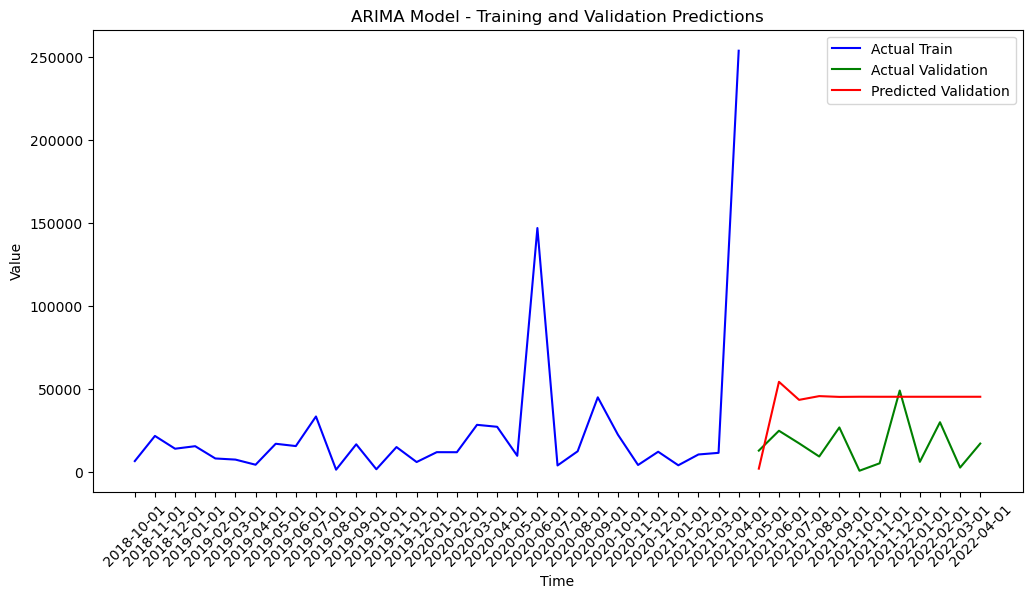

Results appended to ./modelling_csvs/36_results.csv

 Training model for Product Category 8


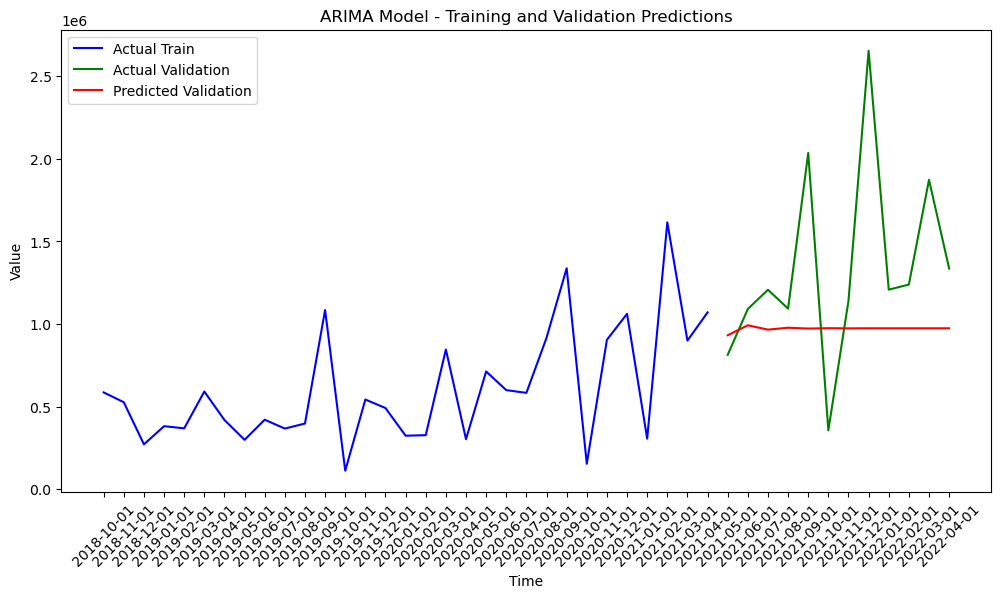

Results appended to ./modelling_csvs/8_results.csv

 Training model for Product Category 20


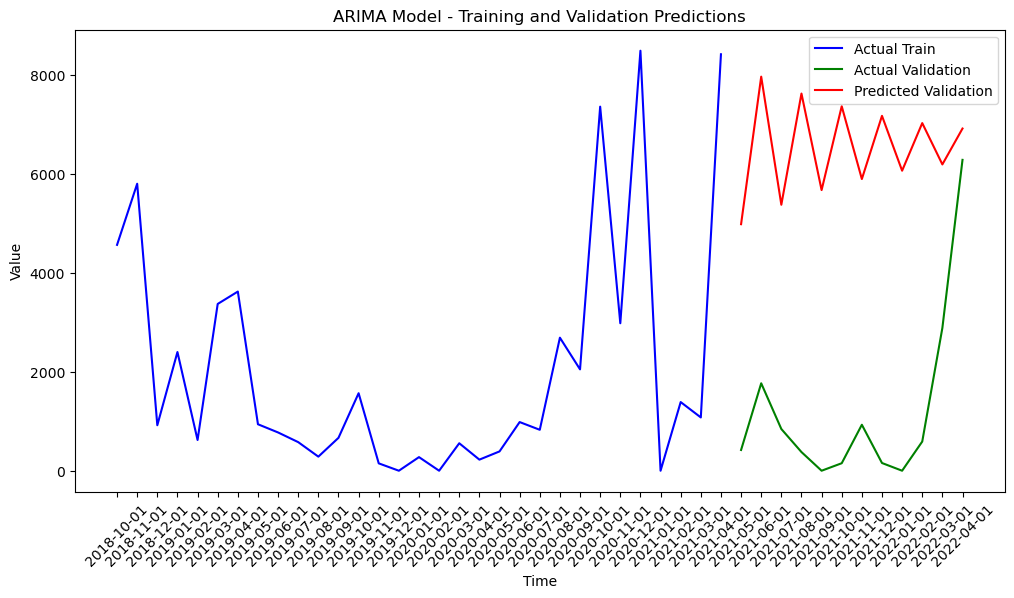

Results appended to ./modelling_csvs/20_results.csv

 Training model for Product Category 9


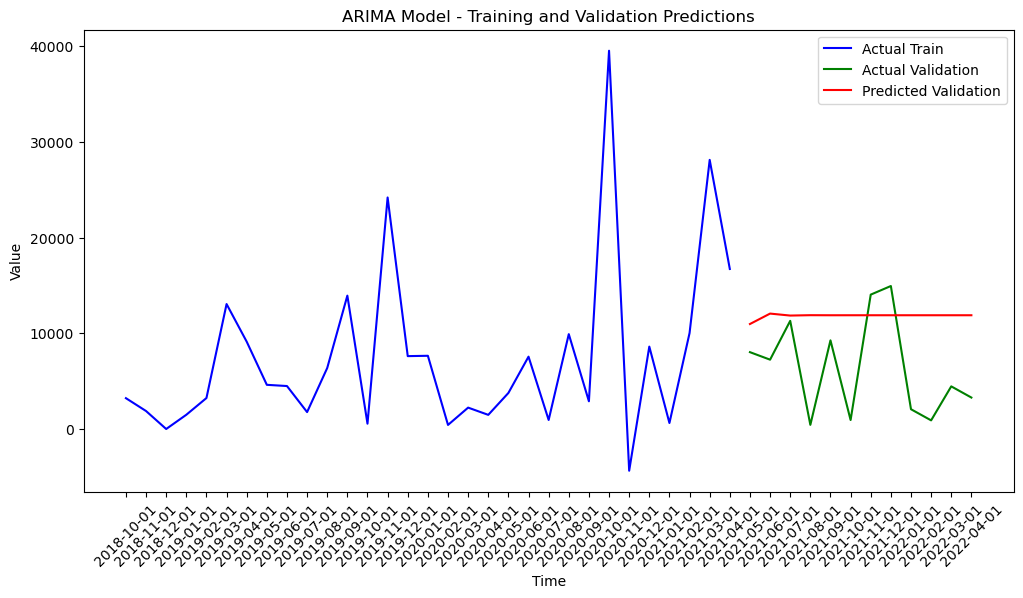

Results appended to ./modelling_csvs/9_results.csv

 Training model for Product Category 4


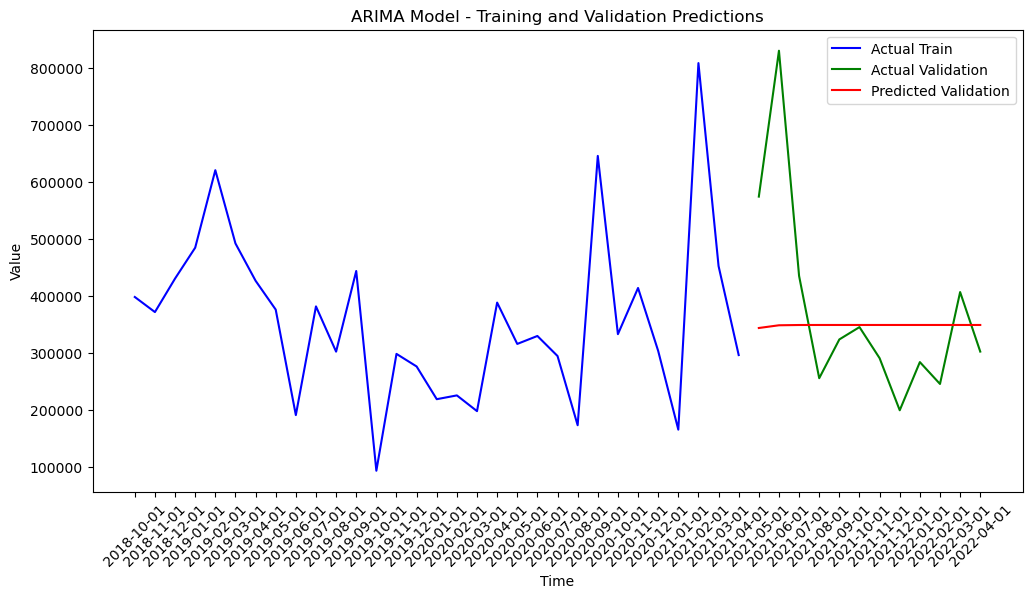

Results appended to ./modelling_csvs/4_results.csv

 Training model for Product Category 11


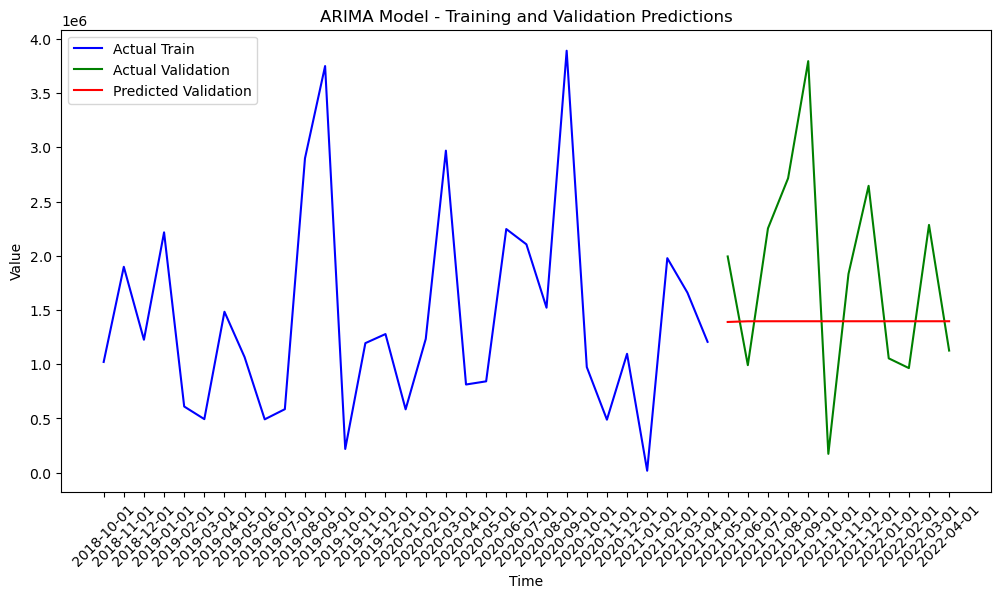

Results appended to ./modelling_csvs/11_results.csv

 Training model for Product Category 5


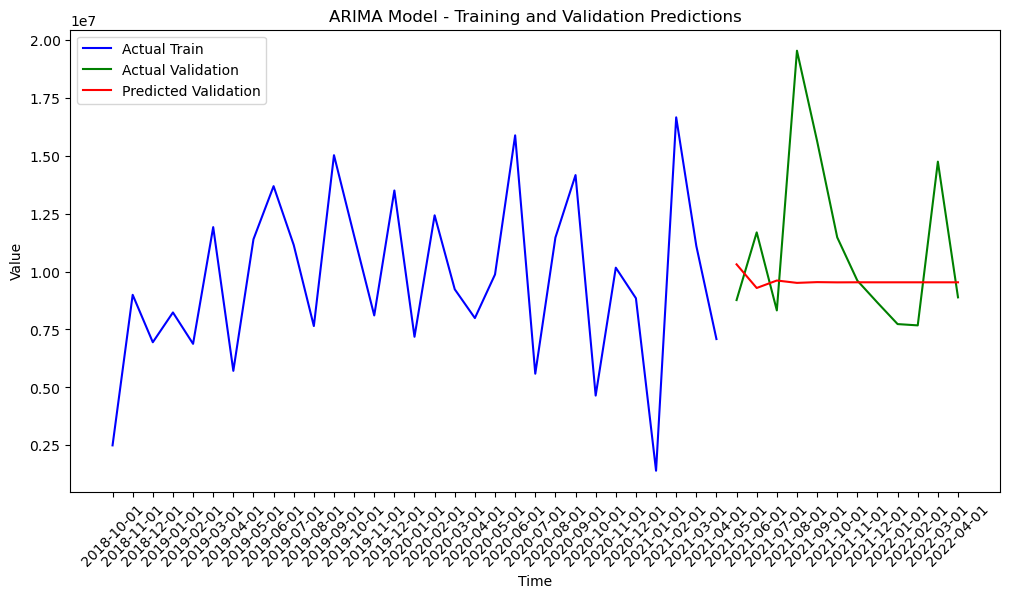

Results appended to ./modelling_csvs/5_results.csv

 Training model for Product Category 12


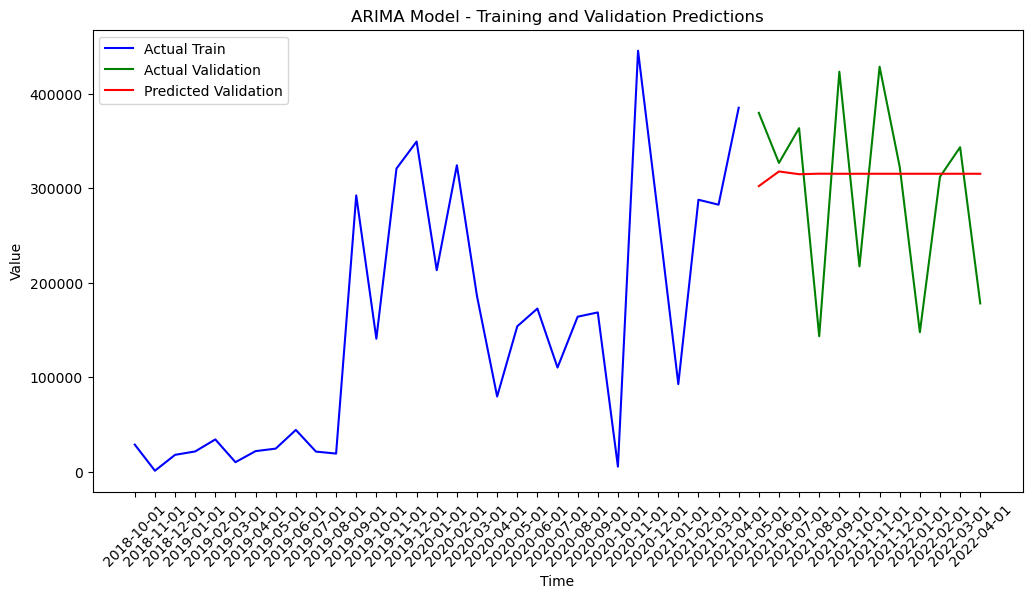

Results appended to ./modelling_csvs/12_results.csv

 Training model for Product Category 13


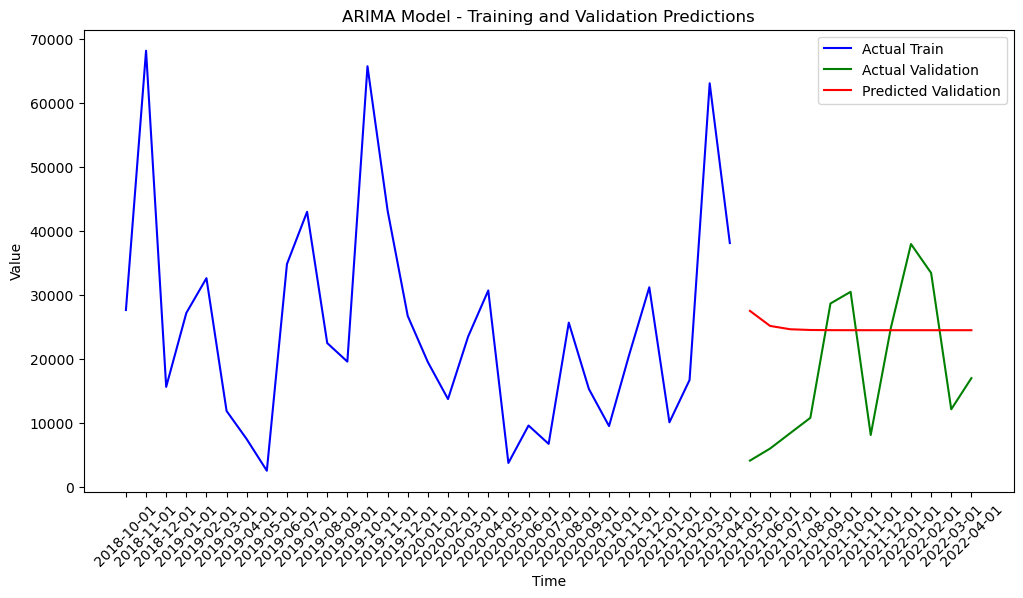

Results appended to ./modelling_csvs/13_results.csv

 Training model for Product Category 6


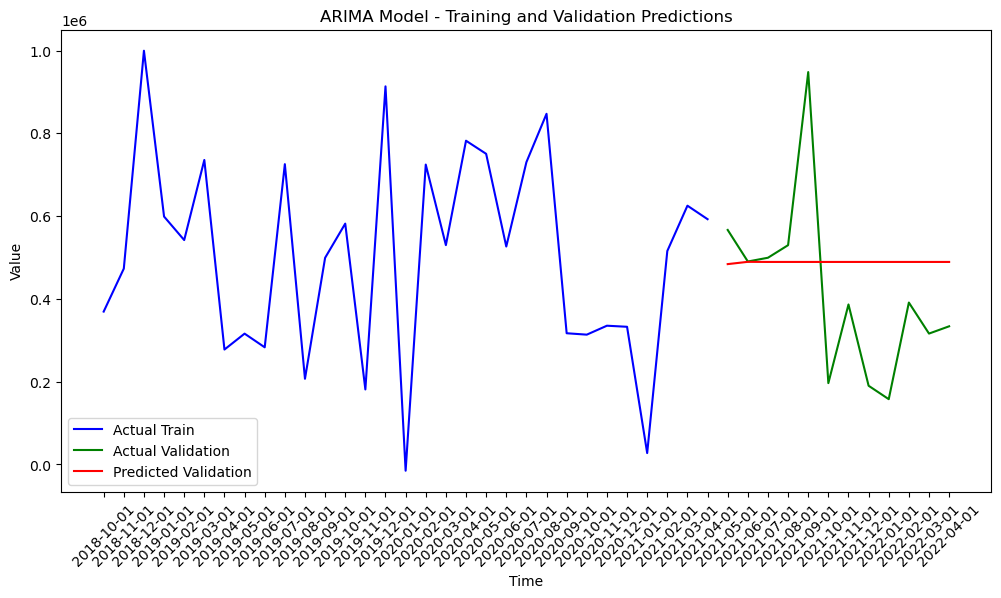

Results appended to ./modelling_csvs/6_results.csv

 Training model for Product Category 16


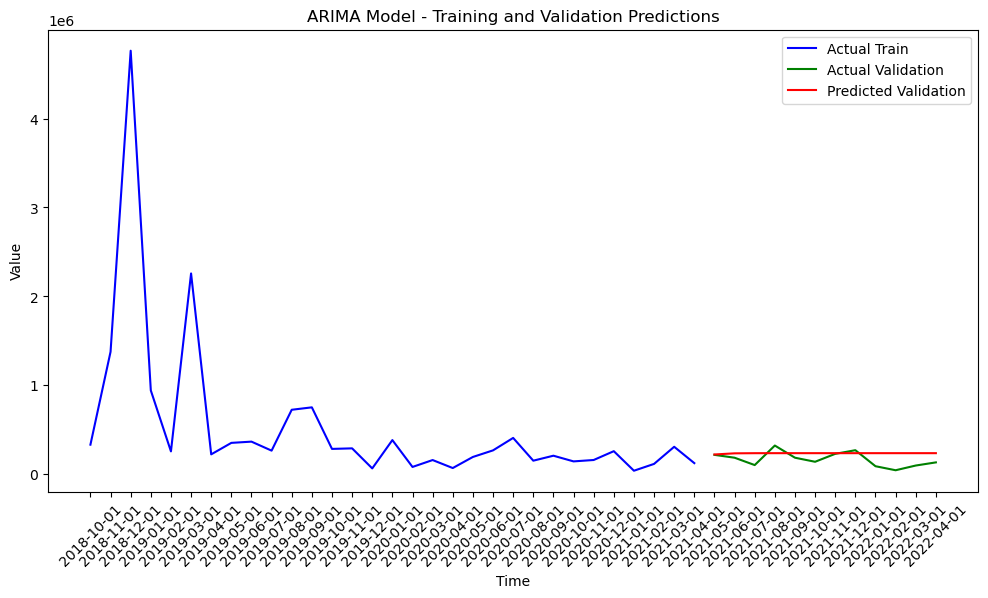

Results appended to ./modelling_csvs/16_results.csv

 Training model for Product Category 3


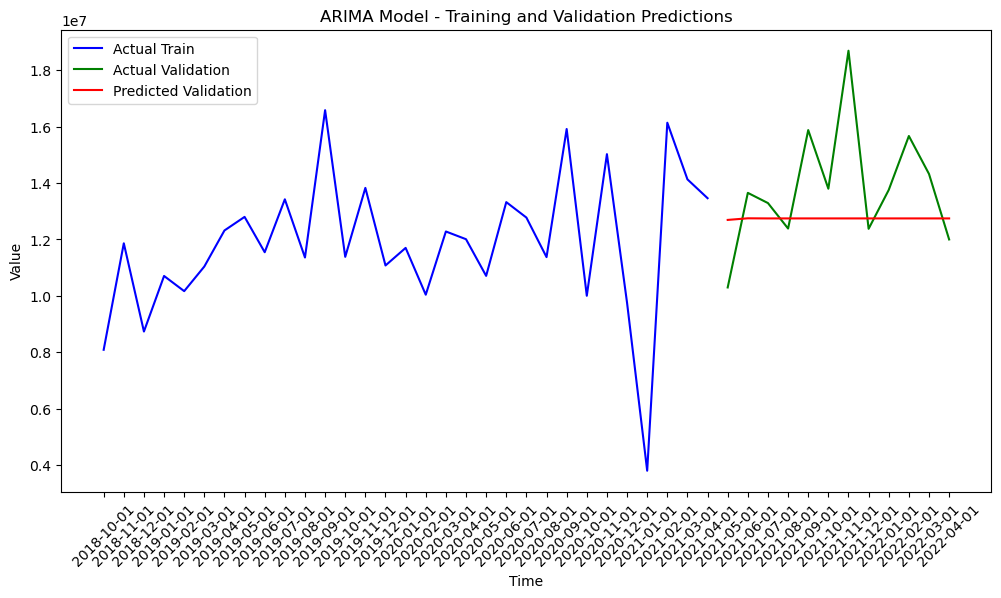

Results appended to ./modelling_csvs/3_results.csv

 Training model for Product Category 1


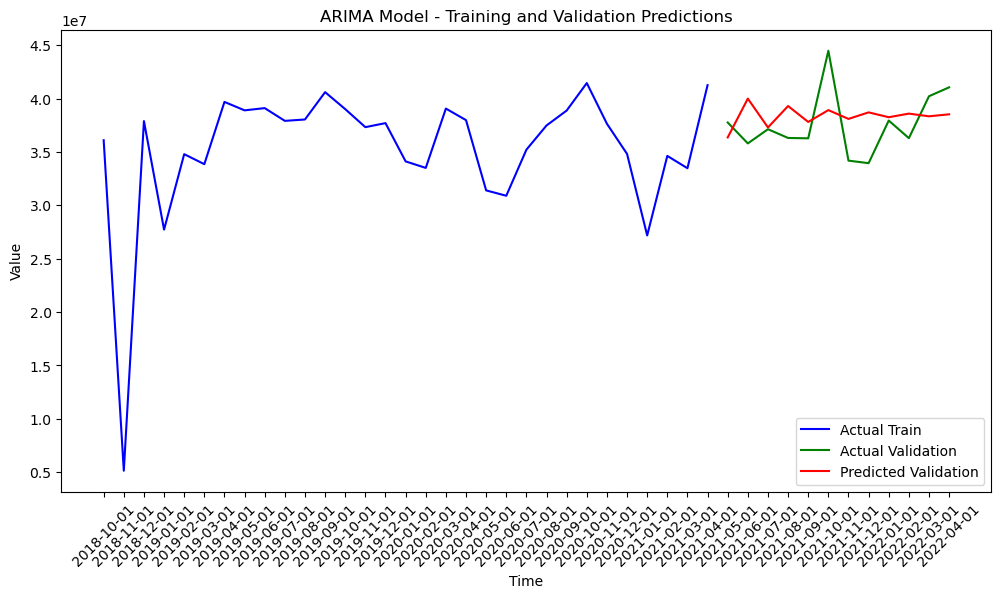

Results appended to ./modelling_csvs/1_results.csv

 Training model for Product Category 14


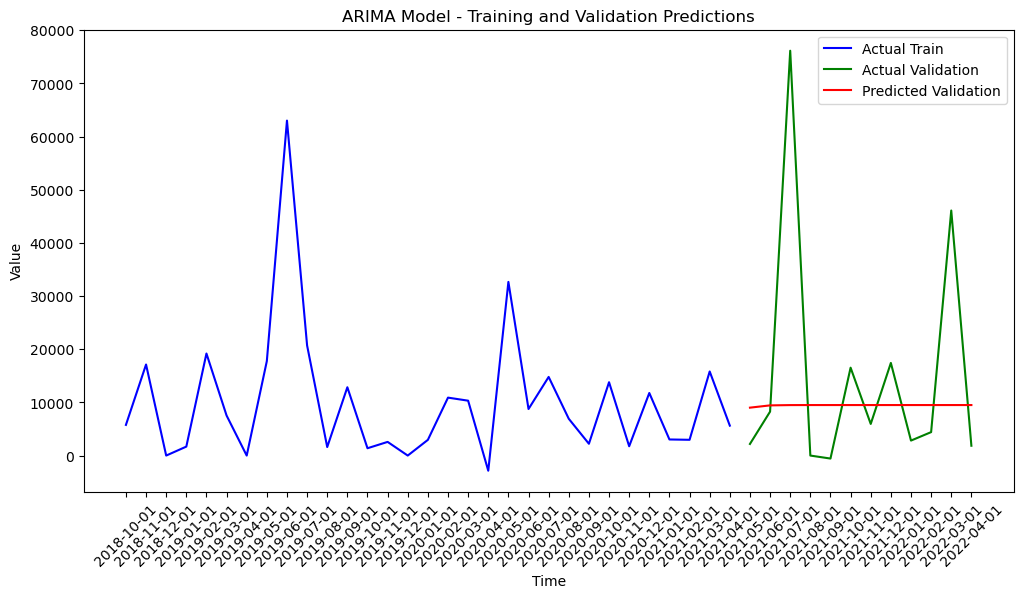

Results appended to ./modelling_csvs/14_results.csv


In [21]:
# Empty dicts
model_fits = {}
val_preds = {}
model_summaries = {}

# ARIMA for all Product Categ
for target_name, selected_features in u.fs_mm_xgb.items():
    target_train = globals().get(f'y_train_{target_name.split("_")[-1]}')
    target_val = globals().get(f'y_val_{target_name.split("_")[-1]}')

    target_number = target_name.split('_')[-1]

    print(f'\n Training model for Product Category {target_number}')

    # Fit the ARIMA model using fs.stats_models method
    model_fits[target_number], val_preds[target_number], model_summaries[target_number] = fs.stats_models(
        'arima', X_train_scaled, X_val_scaled, 
        target_train, target_val, order=(1, 1, 1),
        plot=True,
        csv_path=f'./modelling_csvs/{target_number}_results.csv'
    )

In [22]:
#model_fit_ar, val_preds_ar, model_summary_ar = fs.stats_models('arima', X_train_scaled, X_val_scaled, 
#                                     y_train_1, y_val_1, order=(1,1,3),
#                                     plot = False, 
#                                     csv_path = './modelling_csvs/test3.csv')

**Example for prediction on test data**

In [16]:
steps_ahead = 30  # Number of future steps you want to predict
future_preds = model_fits['36'].forecast(steps=steps_ahead)
print(future_preds)


2021-05-01     1923.405189
2021-06-01    54188.938431
2021-07-01    43331.492644
2021-08-01    45586.977697
2021-09-01    45118.431694
2021-10-01    45215.765683
2021-11-01    45195.545885
2021-12-01    45199.746270
2022-01-01    45198.873698
2022-02-01    45199.054963
2022-03-01    45199.017308
2022-04-01    45199.025130
2022-05-01    45199.023505
2022-06-01    45199.023843
2022-07-01    45199.023772
2022-08-01    45199.023787
2022-09-01    45199.023784
2022-10-01    45199.023785
2022-11-01    45199.023785
2022-12-01    45199.023785
2023-01-01    45199.023785
2023-02-01    45199.023785
2023-03-01    45199.023785
2023-04-01    45199.023785
2023-05-01    45199.023785
2023-06-01    45199.023785
2023-07-01    45199.023785
2023-08-01    45199.023785
2023-09-01    45199.023785
2023-10-01    45199.023785
Freq: MS, Name: predicted_mean, dtype: float64


### SARIMAX


 Training model for Product Category 36


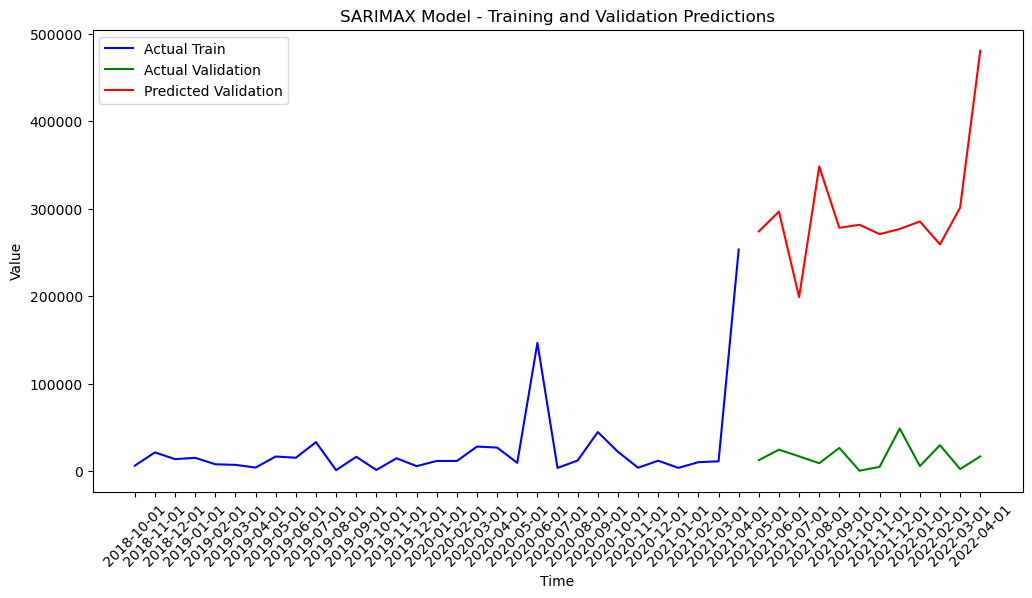

Results appended to ./modelling_csvs/36_results.csv

 Training model for Product Category 8


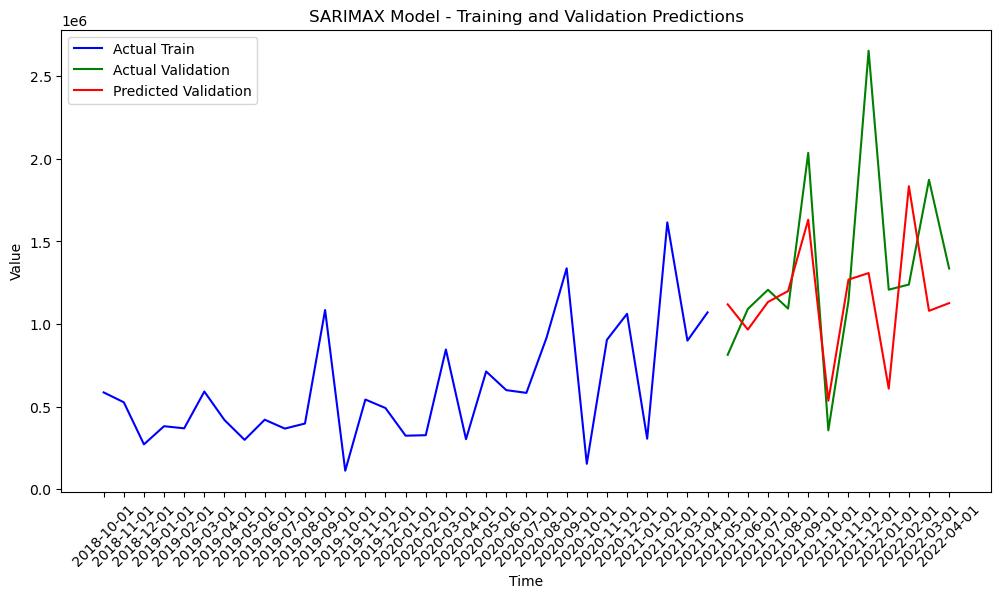

Results appended to ./modelling_csvs/8_results.csv

 Training model for Product Category 20


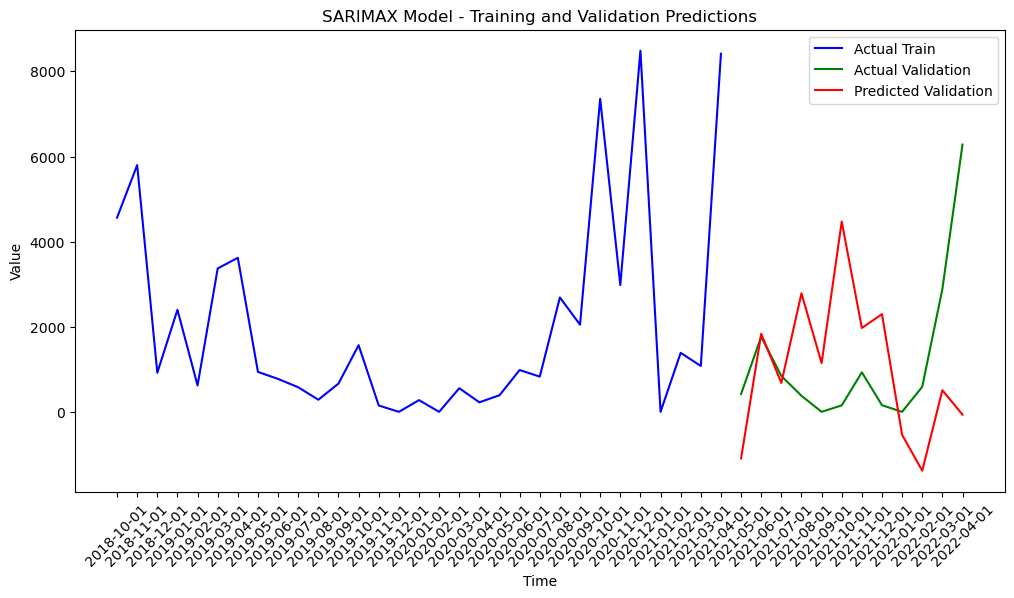

Results appended to ./modelling_csvs/20_results.csv

 Training model for Product Category 9


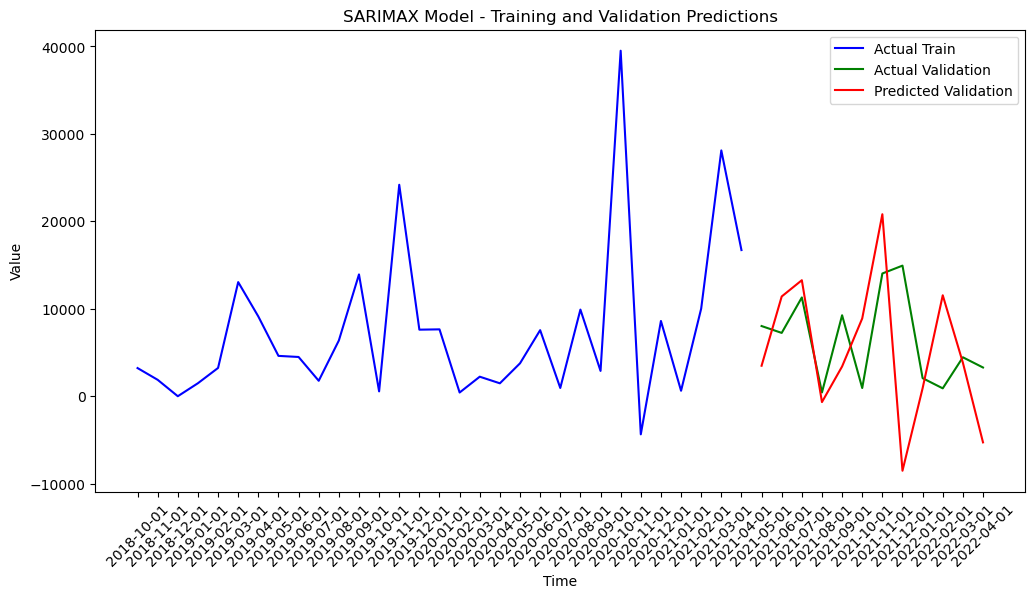

Results appended to ./modelling_csvs/9_results.csv

 Training model for Product Category 4


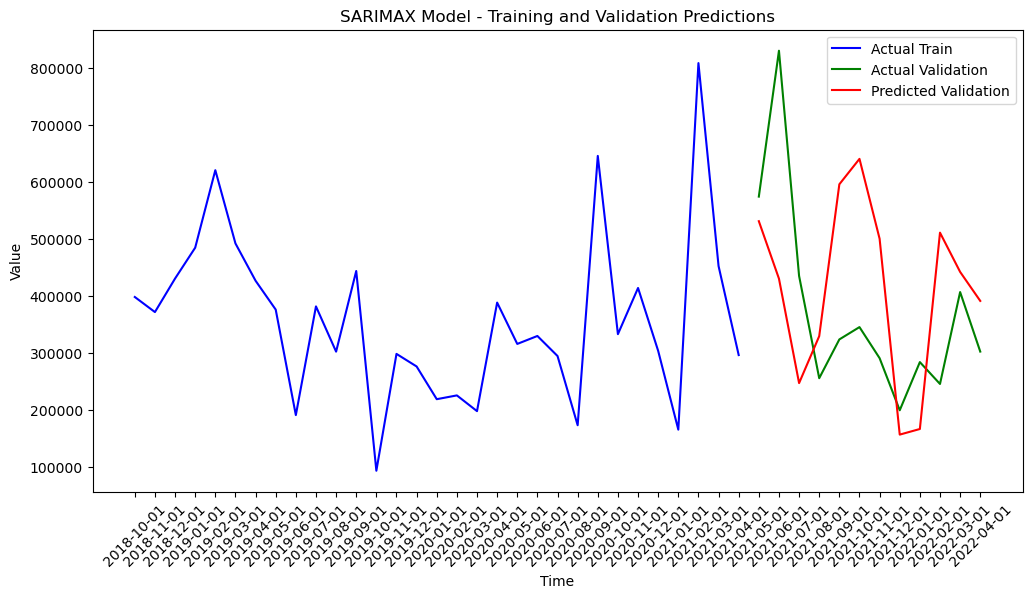

Results appended to ./modelling_csvs/4_results.csv

 Training model for Product Category 11


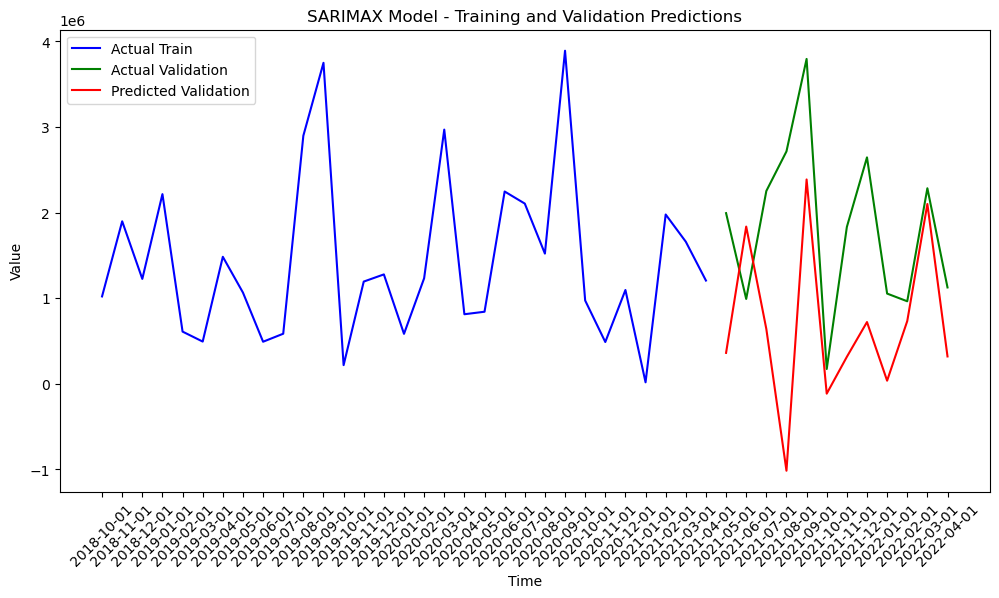

Results appended to ./modelling_csvs/11_results.csv

 Training model for Product Category 5


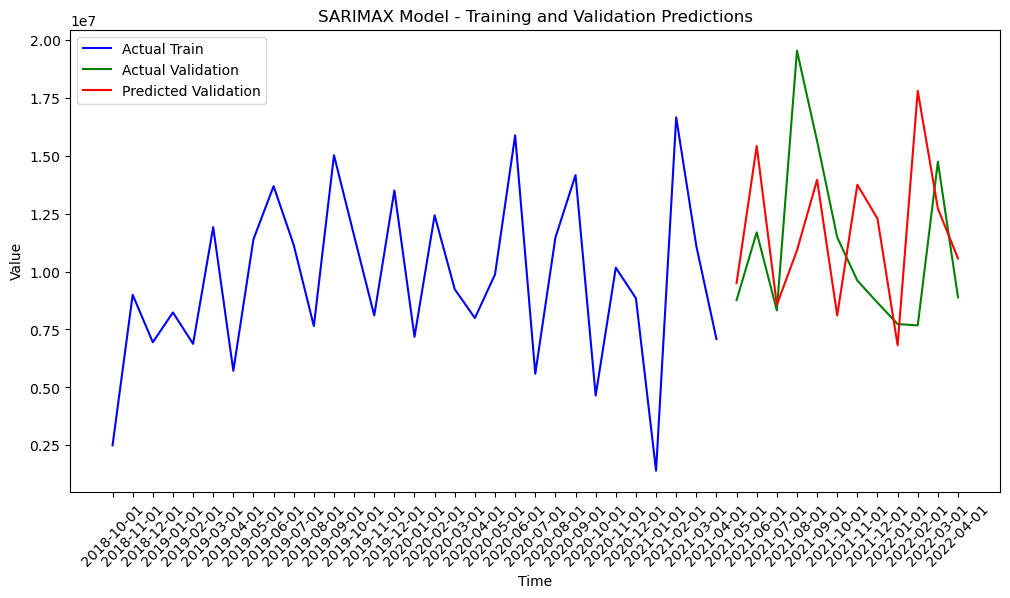

Results appended to ./modelling_csvs/5_results.csv

 Training model for Product Category 12


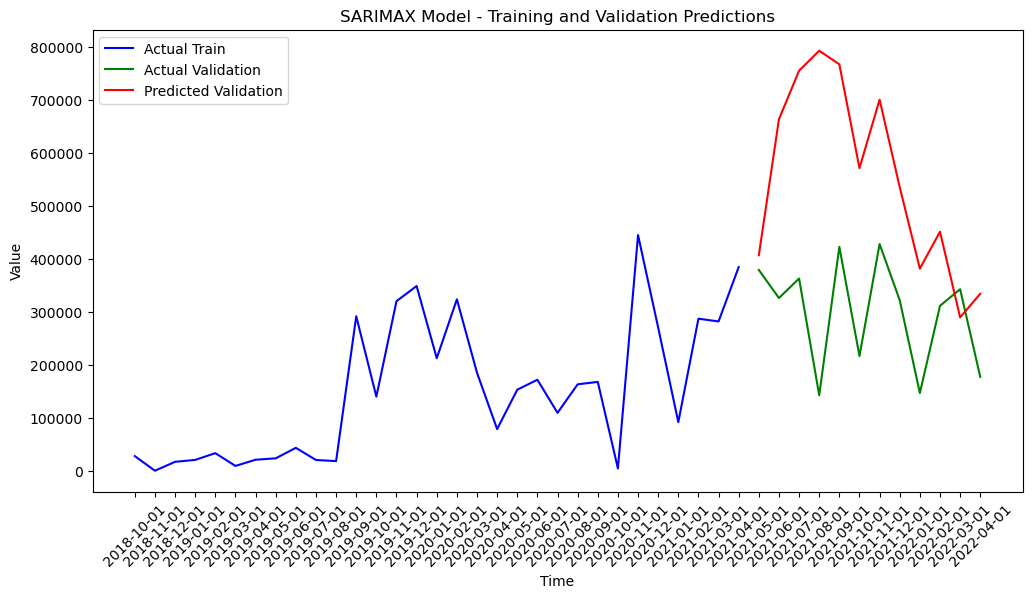

Results appended to ./modelling_csvs/12_results.csv

 Training model for Product Category 13


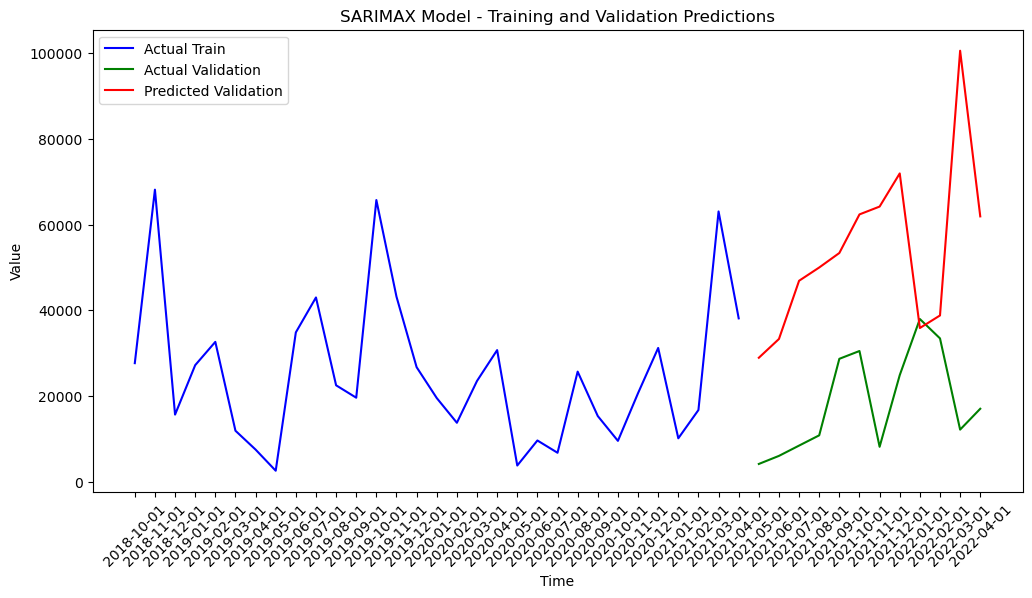

Results appended to ./modelling_csvs/13_results.csv

 Training model for Product Category 6


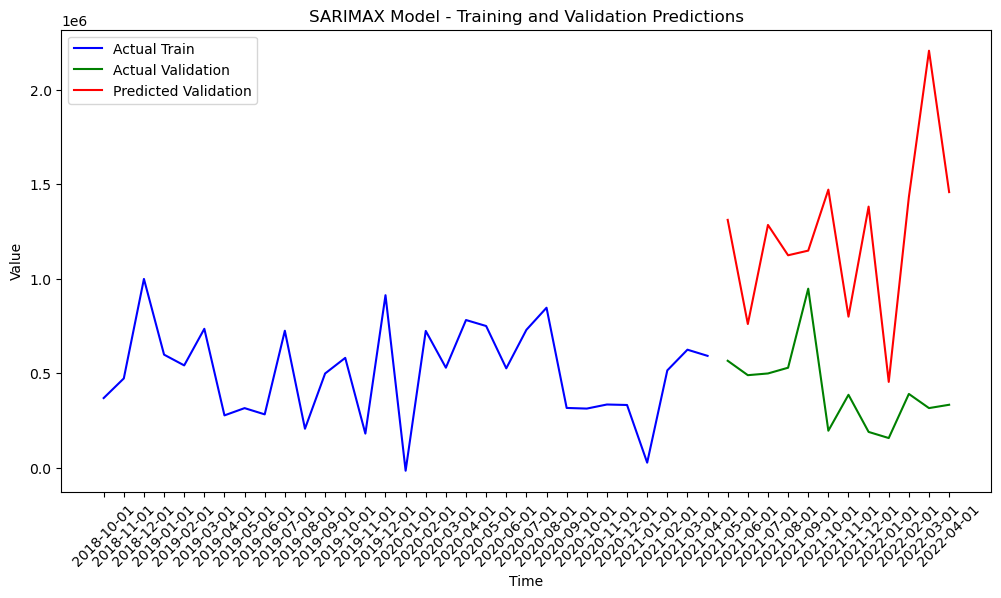

Results appended to ./modelling_csvs/6_results.csv

 Training model for Product Category 16


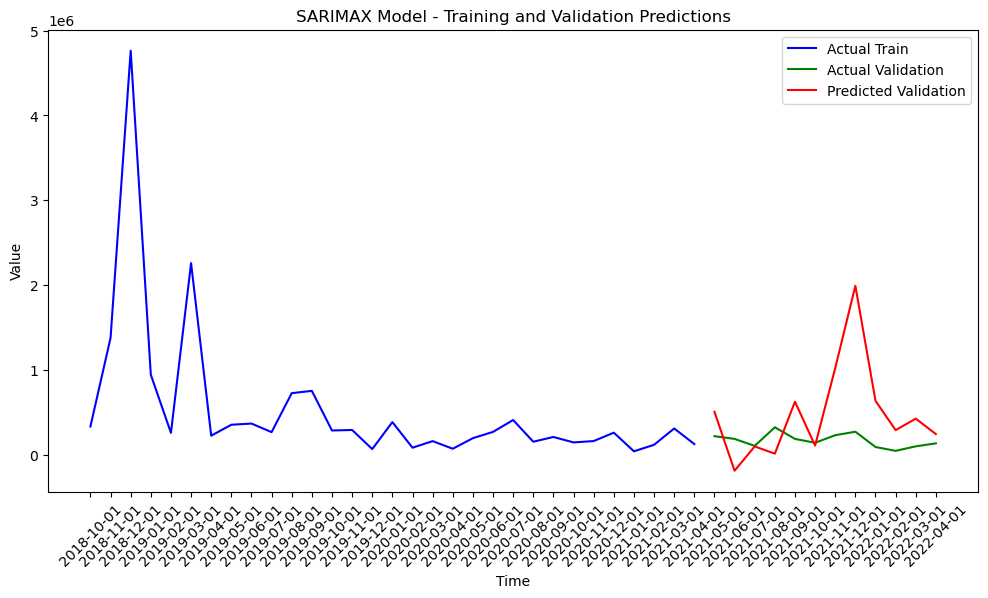

Results appended to ./modelling_csvs/16_results.csv

 Training model for Product Category 3


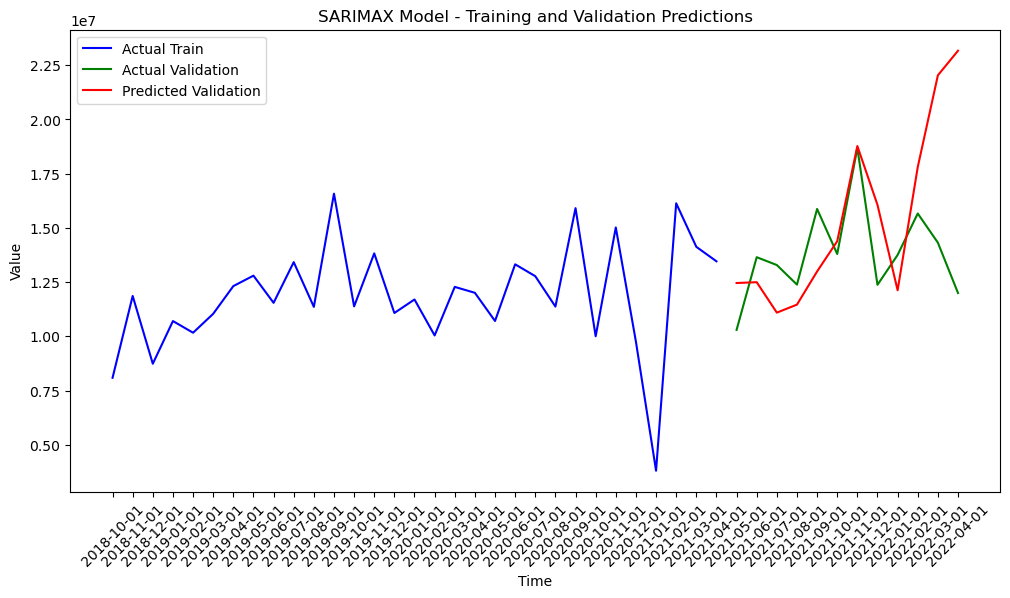

Results appended to ./modelling_csvs/3_results.csv

 Training model for Product Category 1


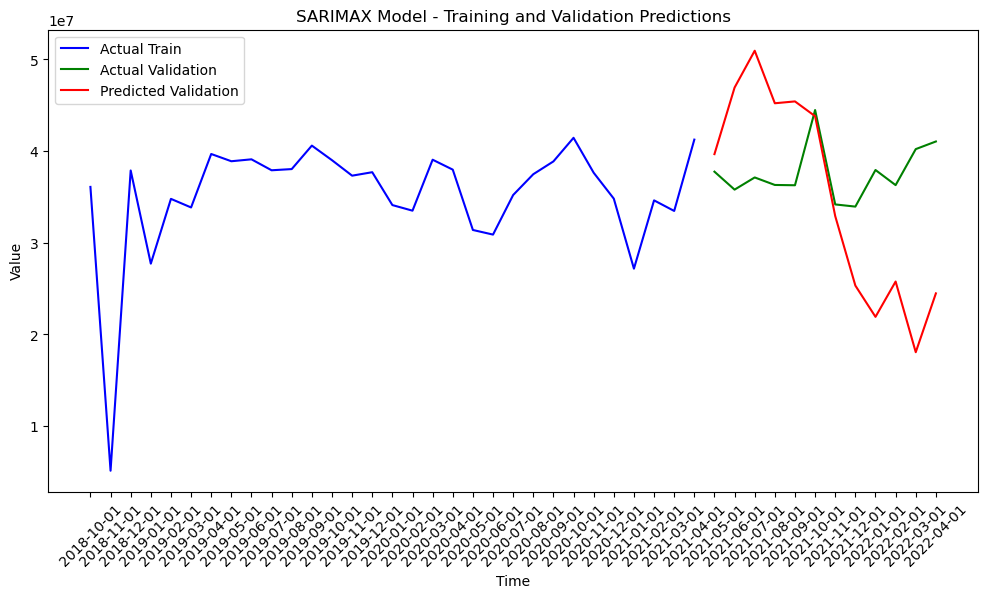

Results appended to ./modelling_csvs/1_results.csv

 Training model for Product Category 14


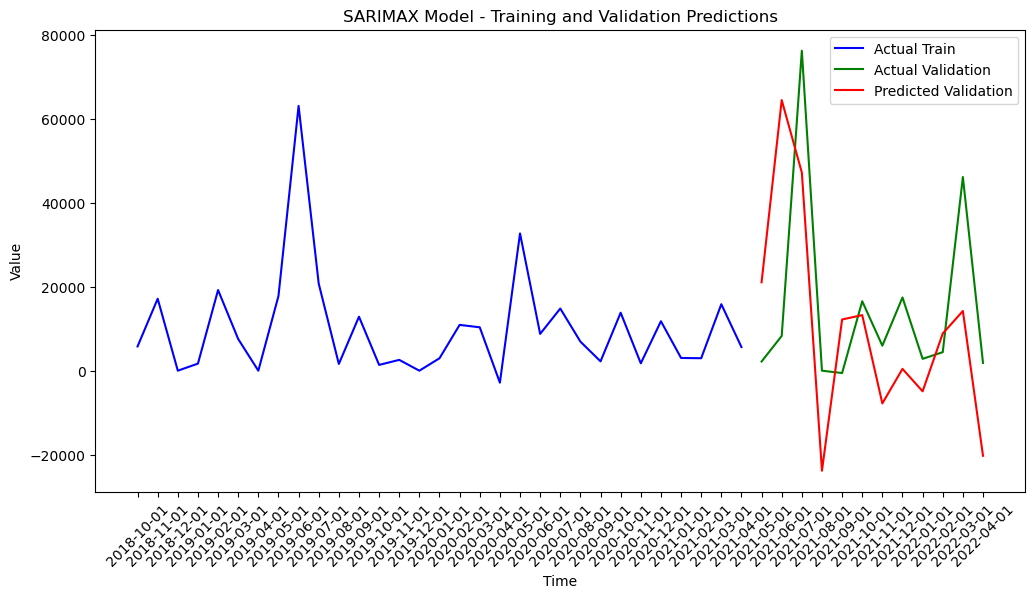

Results appended to ./modelling_csvs/14_results.csv


In [22]:
# Empty dicts
model_fits_sarx = {}
val_preds_sarx = {}
model_summaries_sarx = {}

# SARIMAX for all Product Categ
for target_name, selected_features in u.fs_mm_xgb.items():
    target_train = globals().get(f'y_train_{target_name.split("_")[-1]}')
    target_val = globals().get(f'y_val_{target_name.split("_")[-1]}')

    target_number = target_name.split('_')[-1]

    print(f'\n Training model for Product Category {target_number}')


    # Only selected features
    X_train_target = X_train_scaled[selected_features] 
    X_val_target = X_val_scaled[selected_features] 

    # Fit the SARIMAX model using fs.stats_models method
    model_fits_sarx[target_number], val_preds_sarx[target_number], model_summaries_sarx[target_number] = fs.stats_models(
        'sarimax', X_train_target, X_val_target, 
        target_train, target_val,
        plot=True,
        csv_path=f'./modelling_csvs/{target_number}_results.csv'
    )

In [37]:
#model_fit_sarx, val_preds_sarx, model_summary_sarx = fs.stats_models('sarimax', X_train, X_val, 
#                                     y_train_1, y_val_1, order=(1,1,3),
#                                     plot = False, 
#                                     csv_path = './modelling_csvs/test3.csv')

**Example for prediction on test data**

In [83]:
X_future = X_val # temp
future_preds = model_fit_sarx.forecast(steps=len(X_future), exog=X_future)
print(future_preds)


2021-05-01    3.951051e+07
2021-06-01    4.180620e+07
2021-07-01    4.068981e+07
2021-08-01    4.485621e+07
2021-09-01    4.369701e+07
2021-10-01    4.223861e+07
2021-11-01    3.961871e+07
2021-12-01    4.288582e+07
2022-01-01    3.167765e+07
2022-02-01    3.317506e+07
2022-03-01    3.887002e+07
2022-04-01    4.574127e+07
Freq: MS, Name: predicted_mean, dtype: float64


### Prophet

15:39:36 - cmdstanpy - INFO - Chain [1] start processing



 Training model for Product Category 36


15:39:37 - cmdstanpy - INFO - Chain [1] done processing


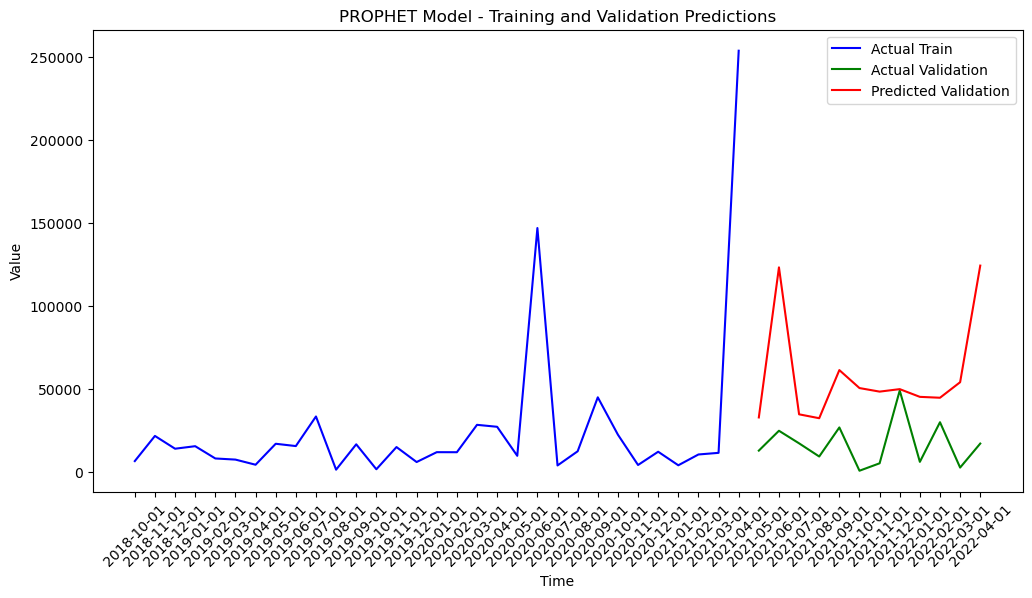

15:39:37 - cmdstanpy - INFO - Chain [1] start processing
15:39:37 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/36_results.csv

 Training model for Product Category 8


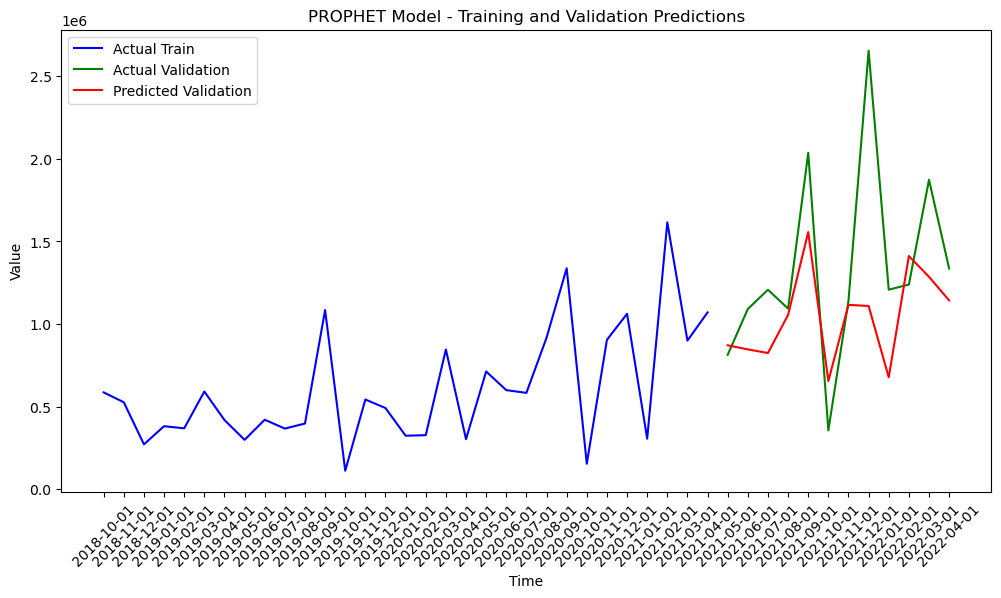

15:39:37 - cmdstanpy - INFO - Chain [1] start processing
15:39:37 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/8_results.csv

 Training model for Product Category 20


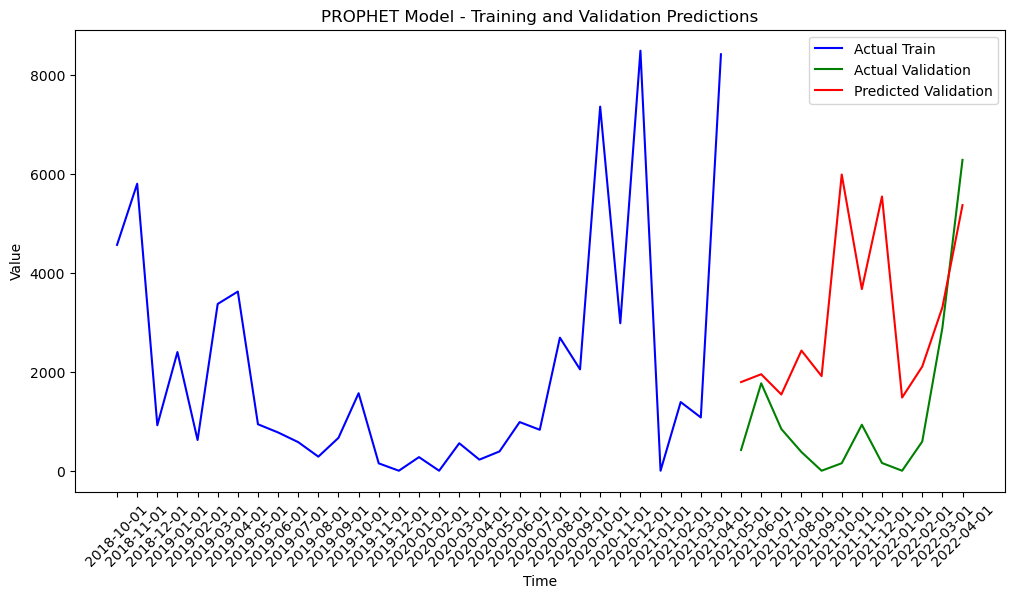

15:39:38 - cmdstanpy - INFO - Chain [1] start processing
15:39:38 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/20_results.csv

 Training model for Product Category 9


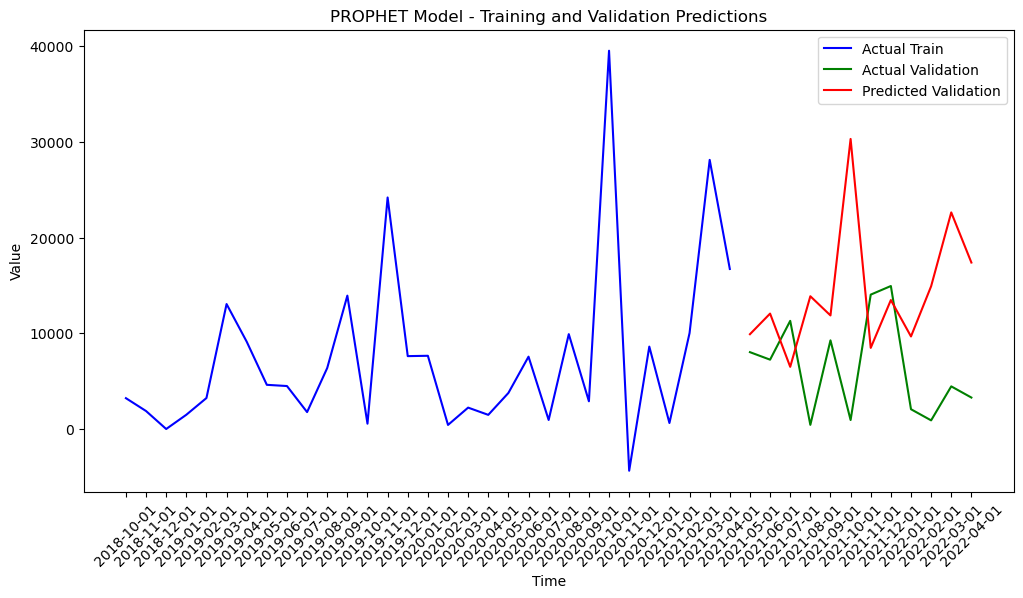

15:39:38 - cmdstanpy - INFO - Chain [1] start processing


Results appended to ./modelling_csvs/9_results.csv

 Training model for Product Category 4


15:39:38 - cmdstanpy - INFO - Chain [1] done processing


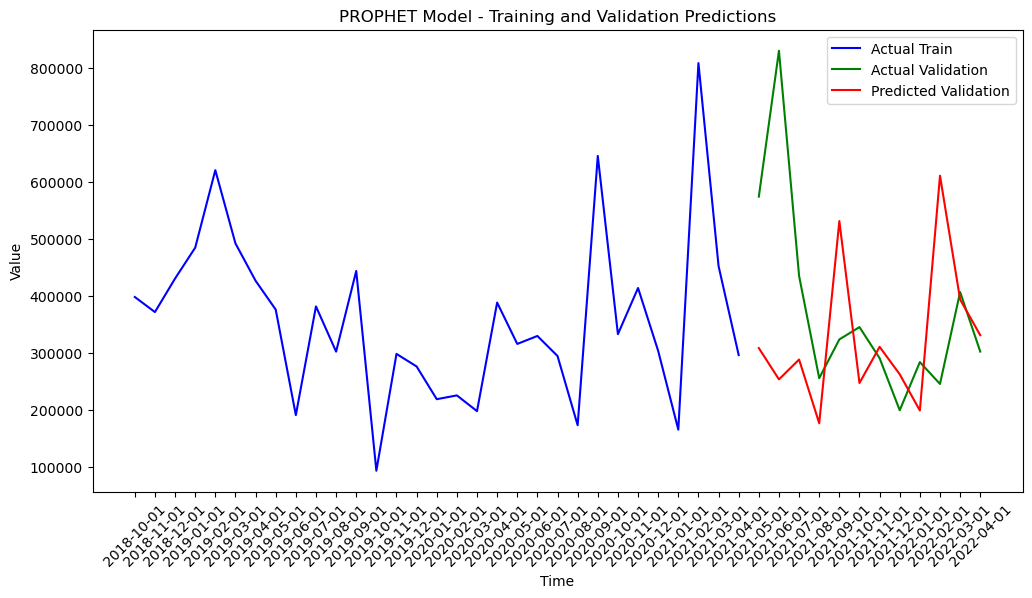

15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/4_results.csv

 Training model for Product Category 11


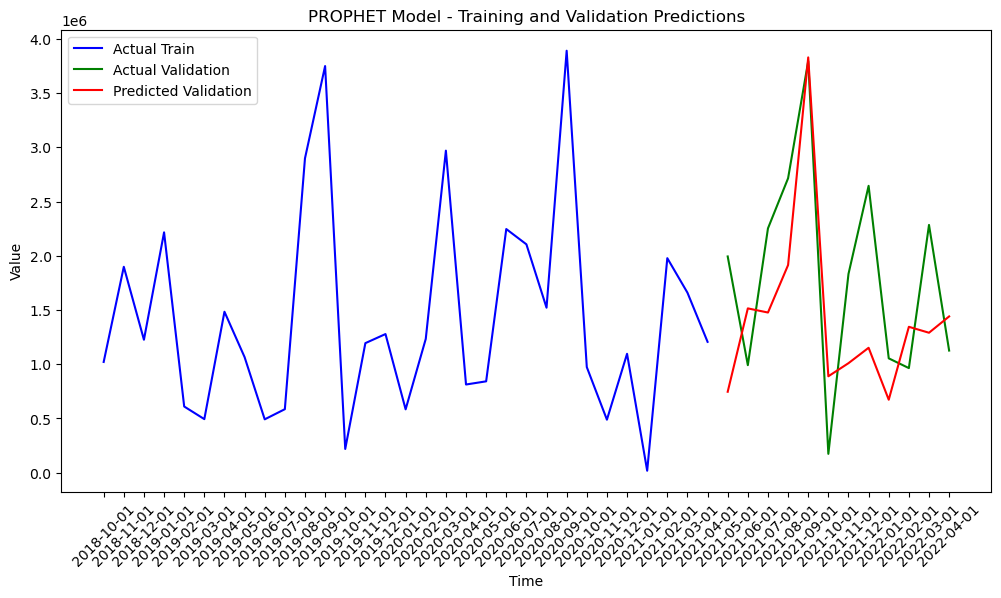

15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/11_results.csv

 Training model for Product Category 5


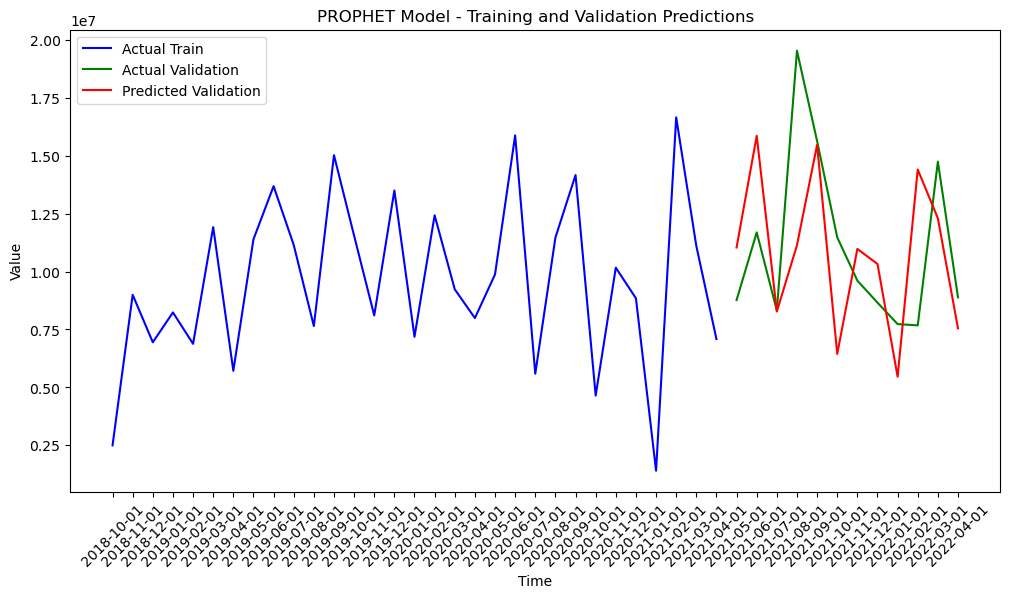

15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/5_results.csv

 Training model for Product Category 12


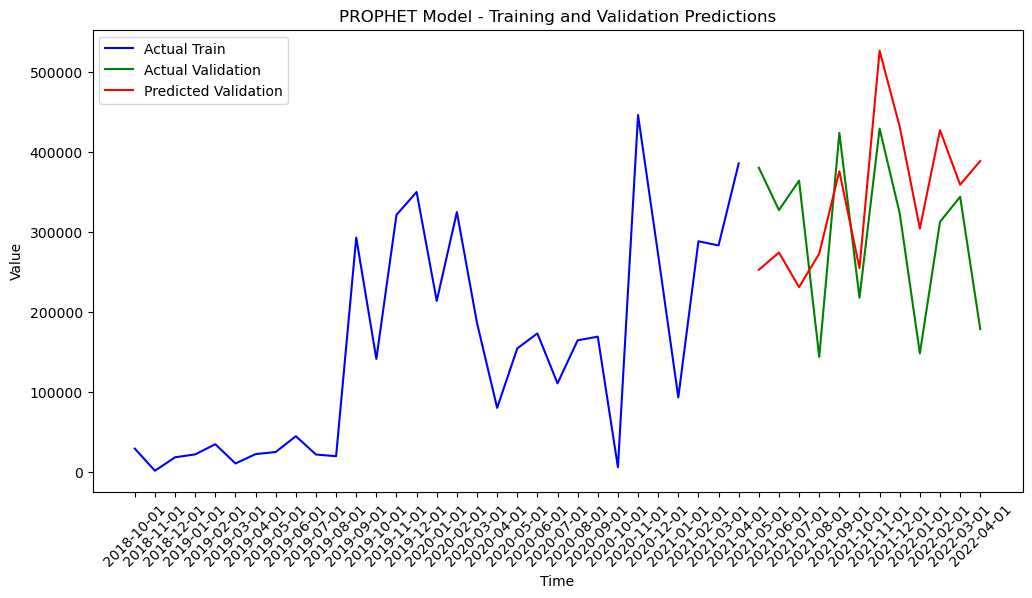

15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/12_results.csv

 Training model for Product Category 13


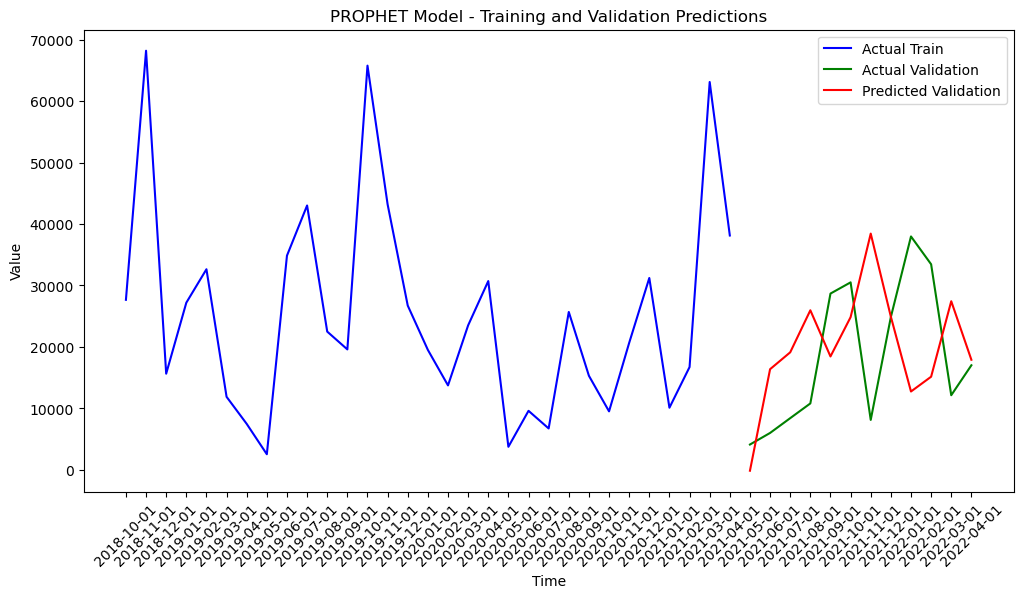

15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:41 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/13_results.csv

 Training model for Product Category 6


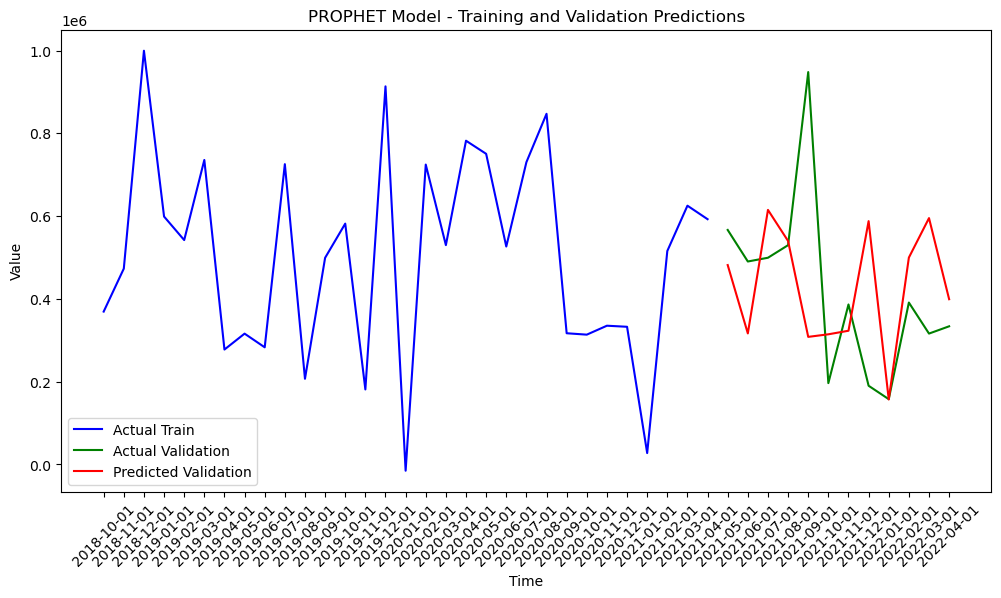

15:39:41 - cmdstanpy - INFO - Chain [1] start processing
15:39:41 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/6_results.csv

 Training model for Product Category 16


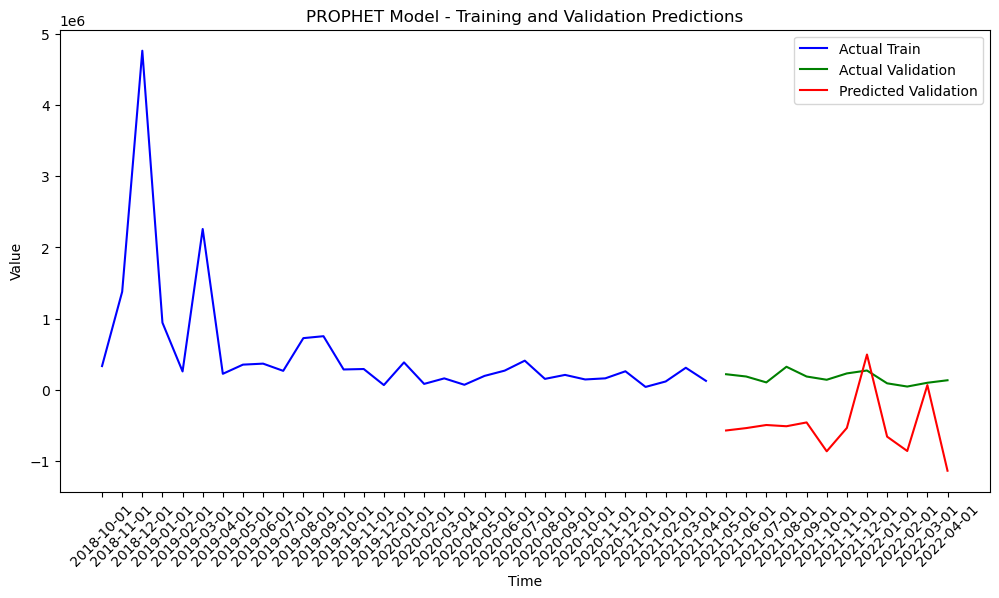

15:39:42 - cmdstanpy - INFO - Chain [1] start processing


Results appended to ./modelling_csvs/16_results.csv

 Training model for Product Category 3


15:39:42 - cmdstanpy - INFO - Chain [1] done processing


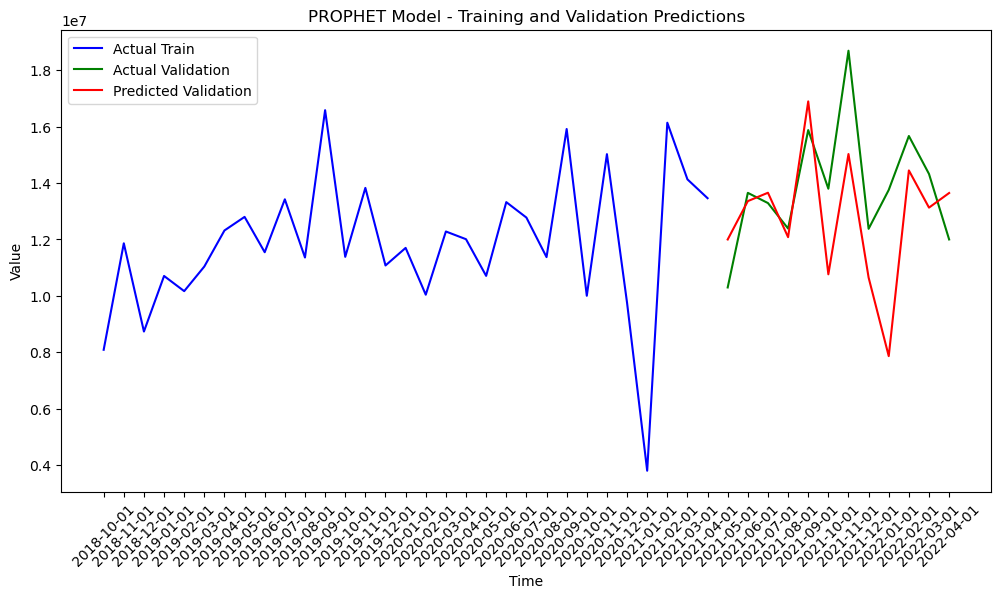

15:39:42 - cmdstanpy - INFO - Chain [1] start processing
15:39:42 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/3_results.csv

 Training model for Product Category 1


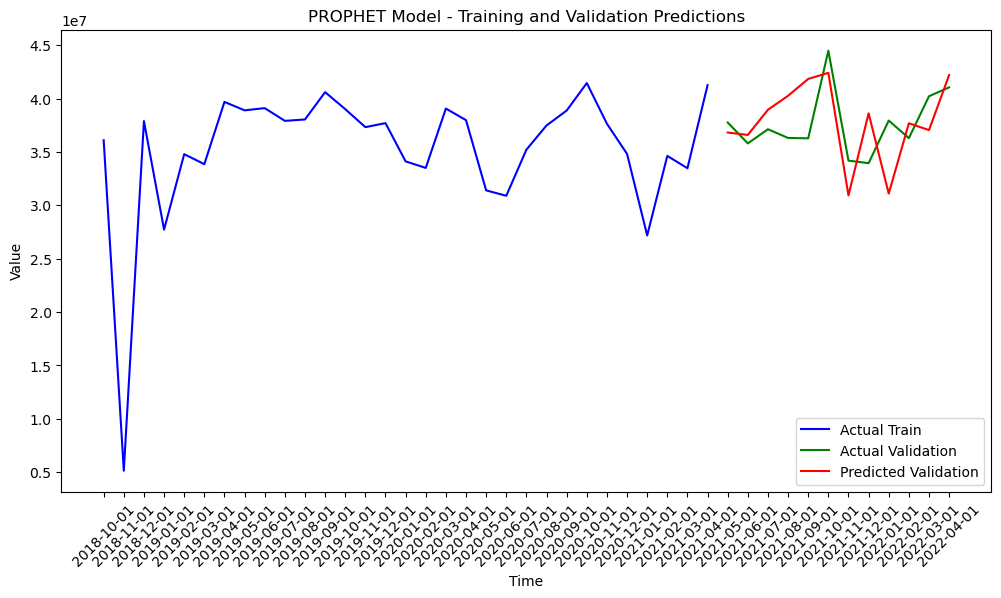

15:39:43 - cmdstanpy - INFO - Chain [1] start processing
15:39:43 - cmdstanpy - INFO - Chain [1] done processing


Results appended to ./modelling_csvs/1_results.csv

 Training model for Product Category 14


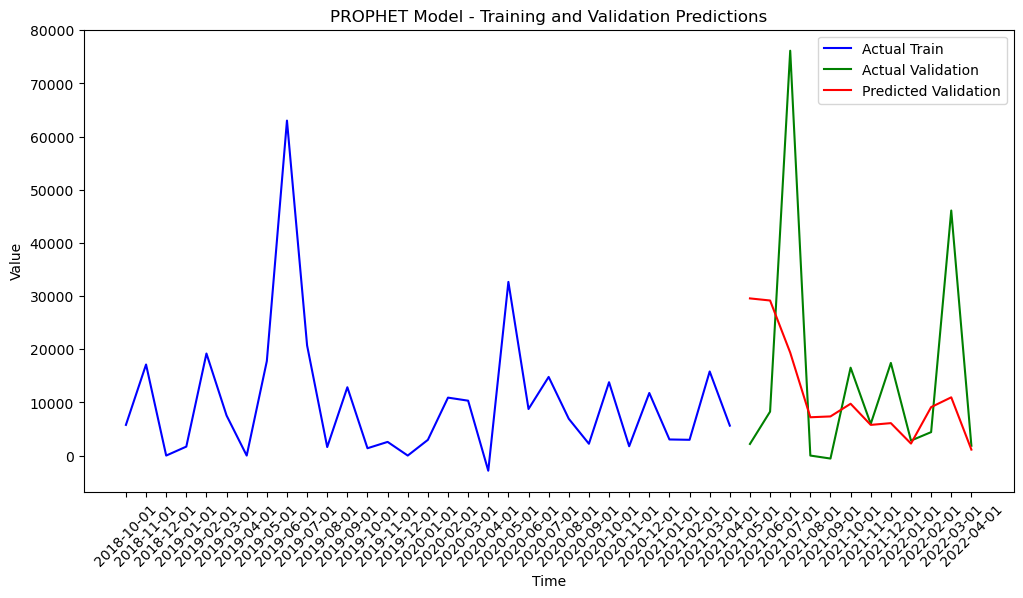

Results appended to ./modelling_csvs/14_results.csv


In [23]:
# Empty dicts
model_fits_p = {}
val_preds_p = {}

# ARIMA for all Product Categ
for target_name, selected_features in u.fs_mm_xgb.items():
    target_train = globals().get(f'y_train_{target_name.split("_")[-1]}')
    target_val = globals().get(f'y_val_{target_name.split("_")[-1]}')

    target_number = target_name.split('_')[-1]

    print(f'\n Training model for Product Category {target_number}')

    # Fit the ARIMA model using fs.stats_models method
    model_fits_p[target_number], val_preds_p[target_number] = fs.stats_models(
        'prophet', X_train_scaled, X_val_scaled, 
        target_train, target_val,
        plot=True,
        csv_path=f'./modelling_csvs/{target_number}_results.csv'
    )

In [17]:
#model_fit_prof, val_preds_prof = fs.stats_models('prophet', X_train, X_val, 
#                                 y_train_1, y_val_1, order=(1,1,3),
#                                 plot = True, 
#                                 csv_path = './modelling_csvs/test3.csv')

**Example for prediction on test data**

In [27]:
future_dates = pd.date_range(start='2022-04-01', periods=10, freq='M')
future_df = pd.DataFrame({'ds': future_dates})

future_preds = model_fits_p['1'].predict(future_df) 
print(future_preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


          ds        yhat  yhat_lower  yhat_upper
0 2022-04-30 44230037.57 38236430.29 50195221.98
1 2022-05-31 44817559.25 38262593.71 51113067.81
2 2022-06-30 39046571.73 32798011.67 45652346.06
3 2022-07-31 39269534.84 33088050.45 45441356.87
4 2022-08-31 44791293.36 39279468.81 51409805.39
5 2022-09-30 39676180.20 33917216.39 45325386.93
6 2022-10-31 23836799.98 18054527.25 29183484.47
7 2022-11-30 49328602.69 43511678.07 55862069.39
8 2022-12-31 44519513.59 37965481.63 50569606.66
9 2023-01-31 36230834.58 30094027.74 42662814.91


### ML Models

In [24]:
# Using ChatGPT help to try to find the error

lazy_model = {}
lazy_pred = {}

# Iterate over fs_mm_xgb and process each target variable
for target_name, selected_features in u.fs_mm_xgb.items():
    try:
        # Extract the corresponding target train and validation data
        target_number = target_name.split('_')[-1]
        
        # Instead of using globals, directly get target_train and target_val
        target_train = globals().get(f'y_train_{target_number}')
        target_val = globals().get(f'y_val_{target_number}')
        
        if target_train is None or target_val is None:
            print(f"Warning: Target data for {target_name} is missing.")
            continue  # Skip to the next target variable if data is missing
        
        # Extract the selected features
        X_train_target = X_train_scaled[selected_features]
        X_val_target = X_val_scaled[selected_features]
        
        # Check if the selected features are valid (no missing columns)
        missing_columns = [col for col in selected_features if col not in X_train_scaled.columns]
        if missing_columns:
            print(f"Warning: Missing columns in selected features for {target_name}: {missing_columns}")
            continue
        
        # Fit LazyRegressor and store results in the dictionaries
        print(f"Fitting LazyRegressor for target {target_name}...")
        lazy_model[target_number], lazy_pred[target_number] = fs.lazy_regressor(
            X_train_target, X_val_target, 
            target_train, target_val, 
            plot=False, 
            csv_path=f'./modelling_csvs/{target_number}_results.csv'
        )
        
        # Instead of checking 'empty', check if a model was trained
        if lazy_model[target_number] is None or isinstance(lazy_model[target_number], Pipeline) and not hasattr(lazy_model[target_number], 'steps'):
            print(f"Warning: No valid model trained for {target_name}.")
            continue

    except Exception as e:
        # Catch and report any errors during the process
        print(f"Error processing {target_name}: {e}")

# For some reason when processing #4 inside the loop we receive an error: attempt to get argmin of an empty sequence
# However, when using the same function for the same #4 outside a loop (bellow) everything works fine

Fitting LazyRegressor for target y_train_36...


100%|████████████████████████████████████████| 42/42 [00:00<00:00, 45.30it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 25734.125630
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 42.60it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 607096.789819
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

100%|████████████████████████████████████████| 42/42 [00:01<00:00, 38.16it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 2062.238703
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 42.35it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 7470.358191
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

100%|████████████████████████████████████████| 42/42 [00:01<00:00, 41.87it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 359307.160534
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 42.95it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 1421567.383065
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet th

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 42.82it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 9577376.875000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet th

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 43.77it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 151350.516003
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 44.58it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 25386.821045
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 43.76it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 504404.891476
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 43.85it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 527741.937500
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 43.95it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 11849899.475806
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 45.77it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 35251444.322581
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet t

100%|████████████████████████████████████████| 42/42 [00:00<00:00, 45.32it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 10086.484977
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the 

100%|████████████████████████████████████████| 42/42 [00:01<00:00, 21.14it/s]


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 0
[LightGBM] [Info] Start training from score 359307.160534
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the

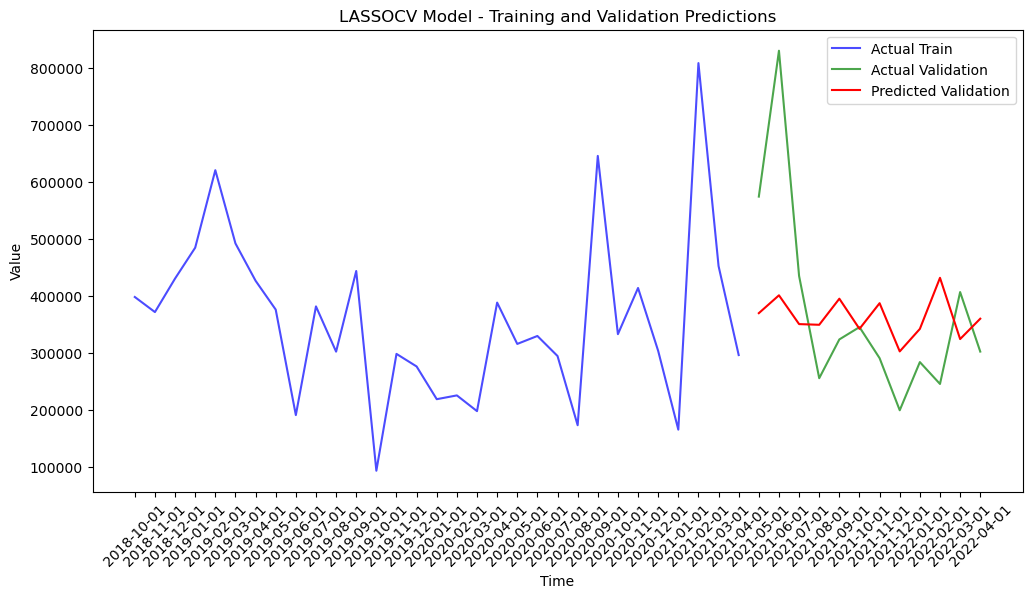

Results appended to ./modelling_csvs/4_results.csv


In [25]:
lazy_model['4'], lazy_pred['4'] = fs.lazy_regressor(X_train_scaled, X_val_scaled, 
               y_train_4, 
               y_val_4, plot = True, 
               csv_path = './modelling_csvs/4_results.csv')

## Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# Fit the model using the training data
model.fit(X_train_1_scaled, y_train_1)

# Make predictions on the validation set
y_pred_val_1 = model.predict(X_val_1_scaled)

# Calculate RMSE for the validation set
rmse_val_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_val_1))
print(f'Root Mean Squared Error on Validation Set: {rmse_val_1}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(y_val_1.index, y_val_1, label='Actual Validation Values', linestyle='-', color='g')
plt.plot(y_val_1.index, y_pred_val_1, label='Predicted Validation Values', linestyle='--', color='g')

plt.plot(y_train_1.index, y_train_1, label='Actual Training Values', linestyle='-', color='b')

plt.xlabel('Date/Time')
plt.ylabel('Sales')
plt.title('XGBoost Forecasting: Actual vs Predicted (Training and Validation)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
